In [13]:
import pickle
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
#import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
#import nilearn as nilearn
#from nilearn import plotting, input_data, image
#from nilearn.image import mean_img
#from nilearn.masking import compute_epi_mask
#from nilearn import datasets, plotting, image
from sklearn.feature_extraction import image
from sklearn.cluster import FeatureAgglomeration
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn import datasets
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.cluster import KMeans
import seaborn as sns
from scipy import stats, integrate
from scipy.stats.mstats import kruskalwallis as kw
import numpy as np
import time as time
import pandas as pd
import statsmodels.api as sm

In [14]:
features = pickle.load( open( "emotype_v10_val.p", "rb" ) )

In [15]:
class2index = {
 'addiction': 2,
 'anxiety': 4,
 'autism': 0,
 'bipolar': 7,
 'conversation': 3,
 'depression': 6,
 'happy': 5,
 'schizophrenia': 1,
}
features[10]['label']


'happy'

In [16]:
X=[]
labels_true=[]
point_index=[]
for i in range(len(features)):
    if features[i]['label']=='depression':
        labels_true.append(class2index[features[i]['label']])
        X.append(features[i]['encoding'])
        point_index.append(i)
X=np.asarray(X, dtype=None, order=None)
X=np.squeeze(X)
labels_true=np.asarray(labels_true, dtype=None, order=None)

In [65]:
X_full=[]
labels_true=[]
point_index=[]
for i in range(len(features)):
    if features[i]['label']!='conversation':
        labels_true.append(class2index[features[i]['label']])
        X_full.append(features[i]['encoding'])  
        point_index.append(i)
X_full=np.asarray(X_full, dtype=None, order=None)
X_full=np.squeeze(X_full)
labels_true=np.asarray(labels_true, dtype=None, order=None)

In [66]:
X_full=np.transpose(X_full)
print(X_full.shape)

(128, 700)


In [67]:
n_components=37
fa= FactorAnalysis(n_components)
fa.fit(X_full)
X=fa.components_

In [68]:
X = StandardScaler().fit_transform(X)
X=np.transpose(X)
print(X.shape)

(700, 37)


In [135]:
def cluster_with_DBSCAN(X, eps, min_samples, verbose=False):
    
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
 
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    if verbose:
        print("Epsilon: %0.2f" % eps)
        print("Min Samples: %d" % min_samples)
        print('Estimated number of clusters: %d' % n_clusters_)
    
    if n_clusters_ == 0 or np.all(labels == 0):
        if verbose:
            print("Silhouette Coefficient = -1\n")
        return n_clusters_, -1, labels
    
    else:
        silhouette_score = metrics.silhouette_score(X,labels)
        if verbose:
            print("Silhouette Coefficient: %0.3f\n"
              % silhouette_score)
 
        return n_clusters_, silhouette_score, labels

In [136]:
def test_all_clusterings(X, verbose=False):
    
    epsilons = np.arange(start=0.8,stop=3.7,step=0.1)
    min_samples = range(2,11)
    
    DBSCAN_result_vectors = []
    max_score= -np.infty
    for m in min_samples:
        for e in epsilons:
        
            n_clusters, score, labels = cluster_with_DBSCAN(X, e, m, verbose)
            if score>max_score:
                opt_m=m
                opt_e=e
                max_score=score
            DBSCAN_result_vectors.append([m, e, n_clusters, score])
    
    result = pd.DataFrame(DBSCAN_result_vectors,
                 columns = ['min_num_neighbors', 'epsilon', 
                            'num_clusters', 'score'])
    
    return result, opt_e, opt_m



In [137]:
cluster_result, opt_e, opt_m= test_all_clusterings(X, verbose=True)

Epsilon: 0.80
Min Samples: 2
Estimated number of clusters: 8
Silhouette Coefficient: -0.355

Epsilon: 0.90
Min Samples: 2
Estimated number of clusters: 10
Silhouette Coefficient: -0.349

Epsilon: 1.00
Min Samples: 2
Estimated number of clusters: 15
Silhouette Coefficient: -0.478

Epsilon: 1.10
Min Samples: 2
Estimated number of clusters: 15
Silhouette Coefficient: -0.459

Epsilon: 1.20
Min Samples: 2
Estimated number of clusters: 15
Silhouette Coefficient: -0.452

Epsilon: 1.30
Min Samples: 2
Estimated number of clusters: 20
Silhouette Coefficient: -0.430

Epsilon: 1.40
Min Samples: 2
Estimated number of clusters: 24
Silhouette Coefficient: -0.386

Epsilon: 1.50
Min Samples: 2
Estimated number of clusters: 25
Silhouette Coefficient: -0.330

Epsilon: 1.60
Min Samples: 2
Estimated number of clusters: 32
Silhouette Coefficient: -0.310

Epsilon: 1.70
Min Samples: 2
Estimated number of clusters: 37
Silhouette Coefficient: -0.267

Epsilon: 1.80
Min Samples: 2
Estimated number of clusters: 37

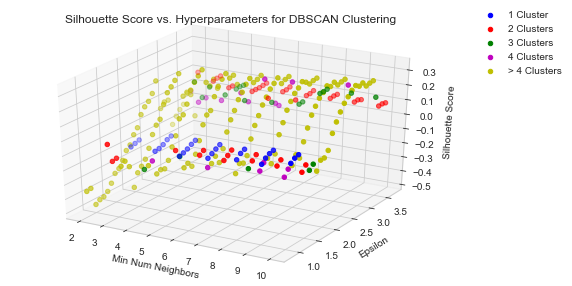

In [144]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')

eps1 = cluster_result.loc[cluster_result['score'] == 0, 'epsilon']
neighbors1 = cluster_result.loc[cluster_result['score'] == 0, 
                                'min_num_neighbors']
scores1 = cluster_result.loc[cluster_result['score'] == 0, 'score']

eps1 = cluster_result.loc[cluster_result['num_clusters'] == 1, 'epsilon']
neighbors1 = cluster_result.loc[cluster_result['num_clusters'] == 1, 
                                'min_num_neighbors']
scores1 = cluster_result.loc[cluster_result['num_clusters'] == 1, 'score']

eps2 = cluster_result.loc[cluster_result['num_clusters'] == 2, 'epsilon']
neighbors2 = cluster_result.loc[cluster_result['num_clusters'] == 2, 
                                'min_num_neighbors']
scores2 = cluster_result.loc[cluster_result['num_clusters'] == 2, 'score']

eps3 = cluster_result.loc[cluster_result['num_clusters'] == 3, 'epsilon']
neighbors3 = cluster_result.loc[cluster_result['num_clusters'] == 3, 
                                'min_num_neighbors']
scores3 = cluster_result.loc[cluster_result['num_clusters'] == 3, 'score']

eps4 = cluster_result.loc[cluster_result['num_clusters'] == 4, 'epsilon']
neighbors4 = cluster_result.loc[cluster_result['num_clusters'] == 4, 
                                'min_num_neighbors']
scores4 = cluster_result.loc[cluster_result['num_clusters'] == 4, 'score']

eps5 = cluster_result.loc[cluster_result['num_clusters'] >= 5, 'epsilon']
neighbors5 = cluster_result.loc[cluster_result['num_clusters'] >= 5, 
                                'min_num_neighbors']
scores5 = cluster_result.loc[cluster_result['num_clusters'] >= 5, 'score']

ax.scatter(neighbors1,eps1,scores1,c='b',marker='o', label = '1 Cluster')
ax.scatter(neighbors2,eps2,scores2,c='r',marker='o', label = '2 Clusters')
ax.scatter(neighbors3,eps3,scores3,c='g',marker='o', label = '3 Clusters')
ax.scatter(neighbors4,eps4,scores4,c='m',marker='o', label = '4 Clusters')
ax.scatter(neighbors5,eps5,scores5,c='y',marker='o', label = '> 4 Clusters')

ax.set_xlabel('Min Num Neighbors')
ax.set_ylabel('Epsilon')
ax.set_zlabel('Silhouette Score')

plt.title('Silhouette Score vs. Hyperparameters for DBSCAN Clustering')

handles, labels = ax.get_legend_handles_labels()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.set_style("whitegrid")
fig1 = plt.gcf()
plt.show()
fig1.savefig('bdscan_parameter_search.png', bbox_inches='tight')

In [107]:
#opt_e=2.8
#opt_m=10
n_clusters, score, dbscan_labels=cluster_with_DBSCAN(X, opt_e, opt_m, True)


Epsilon: 2.80
Min Samples: 10
Estimated number of clusters: 7
Silhouette Coefficient: 0.321



In [77]:
def compute_characeristic_phrase(X,labels):
    characeristic_phrase=[]
    characeristic_labels=[]
    cluster_labels=np.unique(labels)
    #print(cluster_labels)
    for l in cluster_labels:
        cluster_ind=np.where(labels==l)
        cluster=X[cluster_ind]
        column=1
        centroid=sum(row[column] for row in cluster)
        centroid=centroid/cluster.shape[0]
        ind=0
        #print(cluster.shape)
        min_distance=np.infty
        for point in cluster:
            dist = np.linalg.norm(centroid-point)
            if dist<min_distance:
                min_distance=dist
                #characeristic_phrase_ind=np.where(X==point)
                characeristic_phrase_ind= np.where((X == point).all(axis=1))
            ind=ind+1
        #print(l)
        #print(characeristic_phrase_ind)
        characeristic_phrase_ind=characeristic_phrase_ind[0][0]
        characeristic_phrase.append(features[point_index[characeristic_phrase_ind]]['text'])
        characeristic_labels.append(features[point_index[characeristic_phrase_ind]]['label'])
    return characeristic_phrase, characeristic_labels



In [78]:
characeristic_phrase_DBSCAN, characeristic_labels_DBSCAN=compute_characeristic_phrase(X,labels)

In [79]:
characeristic_phrase_DBSCAN

['The powerful play goes on and you may contribute a verse.https:www.youtube.comwatch?vvi0Lbjs5ECI',
 "I am going through a painful breakup and my coping mechanism is to make myself better! Here's my list so far but I want more ideas:  Started therapy Get a session with a stylist Personal trainer Drinking more water Teeth Whitening Seeking a life coach to organize my career goals Haircut",
 "So I see alot of people on here talk about they hear their name being called alot. I have the same when I hit rock bottom, is there any correlation between hallucinations and name calling? Mine is always a middle aged girl. Or I'll hear people say my name in a conversation but nobody said my name.",
 'Loud sounds such as loud talking, lawnmowers, fireworks, etc. Involuntarily sounds are causing me sudden amounts of stress pain and I know that my younger brother once had these types earmuffs specifically for autism. Unfortunately, I probably couldn t afford them. So, would protective(construction ho

In [80]:
characeristic_labels_DBSCAN

['happy',
 'happy',
 'schizophrenia',
 'autism',
 'anxiety',
 'addiction',
 'anxiety',
 'bipolar']

In [145]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture


lowest_bic = np.infty
bic = []
n_components_range = range(1, 40)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        print(gmm.covariances_.shape)
        print(gmm.bic(X))
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            best_n_components=n_components
            best_cv_type=cv_type

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
print(lowest_bic)
print(best_gmm.covariances_.shape)




(1,)
65369.07152139772
(2,)
62672.62857546479
(3,)
56056.93170887508
(4,)
48144.95445620686
(5,)
44860.782357774035
(6,)
40327.3221206512
(7,)
38186.45150541364
(8,)
36689.18344892815
(9,)
36316.5607578806
(10,)
36357.51435807476
(11,)
35517.88235260305
(12,)
35519.78344310698
(13,)
34842.75579356919
(14,)
34831.78798643874
(15,)
35228.94003009722
(16,)
34313.852952061665
(17,)
34588.6520289619
(18,)
34134.75247346543
(19,)
34389.68421381271
(20,)
34621.52948856224
(21,)
34326.680736964525
(22,)
34288.779395216814
(23,)
34302.86153629334
(24,)
34110.965115767714
(25,)
34443.7343679502
(26,)
34495.45156207559
(27,)
34354.96298758362
(28,)
34313.331799204185
(29,)
34254.59993426176
(30,)
34329.027320294226
(31,)
34599.834872251275
(32,)
34442.25365687559
(33,)
34356.07466059181
(34,)
34204.54187505386
(35,)
34912.930085913395
(36,)
34661.694823327605
(37,)
34551.104496194304
(38,)
34818.97729328879
(39,)
35087.44817252304
(37, 37)
20309.59077154451
(37, 37)
19310.42403827752
(37, 37)
178

In [40]:
print(best_n_components)
print(best_cv_type)

12
tied


In [97]:
best_n_components=12
best_cv_type='tied'
gmm = mixture.GaussianMixture(n_components=best_n_components,
                                      covariance_type=best_cv_type)
gmm.fit(X)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=12, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [98]:
gmm_labels=gmm.predict(X)

In [99]:
uniqe_labels=np.unique(gmm_labels)

In [100]:
uniqe_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [101]:
characeristic_phrase_GMM, characeristic_labels_GMM=compute_characeristic_phrase(X,gmm_labels)

In [102]:
characeristic_phrase_GMM

['Hello all, I have been on 150mg ven XR for the last year or so. I am tired of the sexual side effects and my doc said I can try a high CDB strain of Cannabis instead of the ven. I am weaning off of the ven now. Anyone else try this before? How did it work out?',
 'I had a job that I loved in a field I m studying for. I got started on medication that seems to be helping. Seeing a therapist regularly. Started communicating better with my friends and SO.    aaaaaaaaaaand  Then I walked out of my job because my manager said something to piss me off. This was 4 days ago and I haven t been back since. Definitely getting fired for doing no call no shows. Such is the life of a borderline. ',
 "So I see alot of people on here talk about they hear their name being called alot. I have the same when I hit rock bottom, is there any correlation between hallucinations and name calling? Mine is always a middle aged girl. Or I'll hear people say my name in a conversation but nobody said my name.",
 '

In [103]:
characeristic_labels_GMM

['anxiety',
 'bipolar',
 'schizophrenia',
 'autism',
 'happy',
 'anxiety',
 'schizophrenia',
 'anxiety',
 'happy',
 'autism',
 'anxiety',
 'schizophrenia']